In [1]:
%reset
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functions import loader, splt, fitter, stats
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from uncertainties import *
from uncertainties import unumpy as unp

savedir = "D04/"

In [12]:
## Choose if is better with dedicated data...

data = loader.load_data( "../CloudVenetoAnalysisBis/20220611UngaussianityBySizeHighRes*/**/" )
len( data )

## Or with all data

# all_data = loader.load_data()
data = loader.remove_duplicates( data,
    lambda d: ( d['dep_polymers'], d['side'], d['defects_frac'], d['gamma'] ),
    lambda d: d['runned_replicas']
)
# data = data[ np.vectorize( lambda d: ( d['gamma'] == 0.4 ) and ( d['defects_frac'] == 0.2 ) )( data ) ]
data = data[ np.argsort( [ d['side'] for d in data ] ) ]
len( data )

12

d:\Dropbox\Gali\Tesi\RSA_problem\Analysis\functions\fitter.py:108: RuntimeWarning: overflow encountered in exp
  return np.log( pref ) - a * ( b * ( x - u ) + np.exp( - b * ( x - u ) ) )
c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


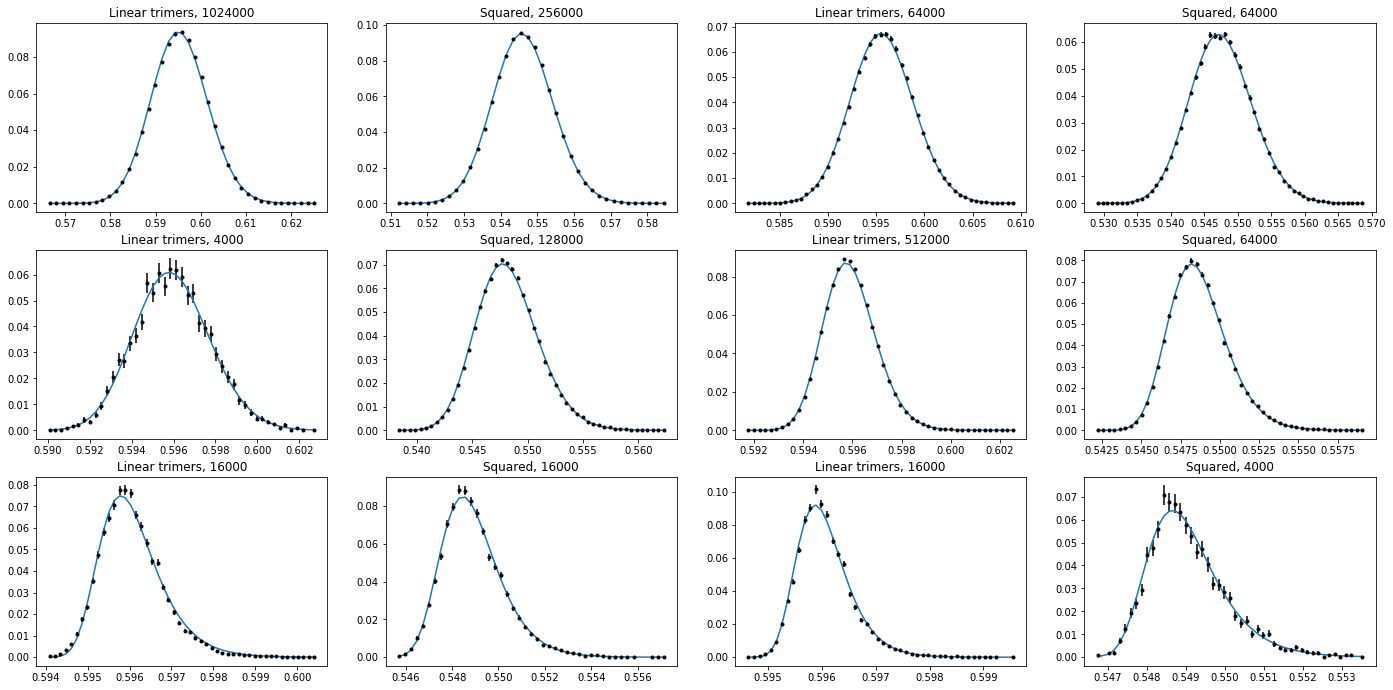

In [13]:
splt.init( 4, 4 )

for d in data:
    splt.next()

    rr = d['runned_replicas']
    x, y = fitter.rebin_n( d['h_x'], d['h'], 50 )
    d['fits'] = fitter.entropyc_fits( d['xs'], x )
    d['fits_x'] = x
    
    plt.plot( x, d['fits']['GG']['est_y'], label="GG" )
    plt.errorbar( x, y, np.sqrt( np.array ( y ) / rr ), color='k', marker='.', ls='' )

    # plt.yscale( 'log' )

    plt.title( d['dep_polymers'] + f", {rr}" )

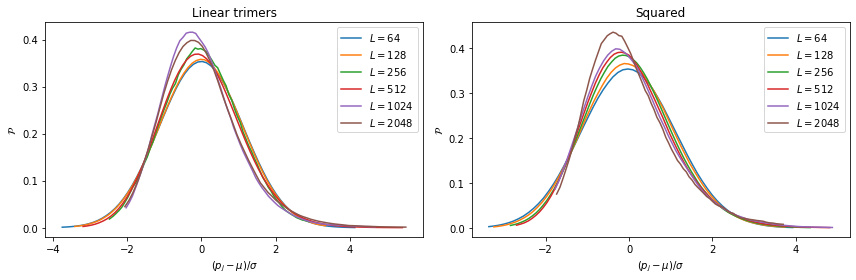

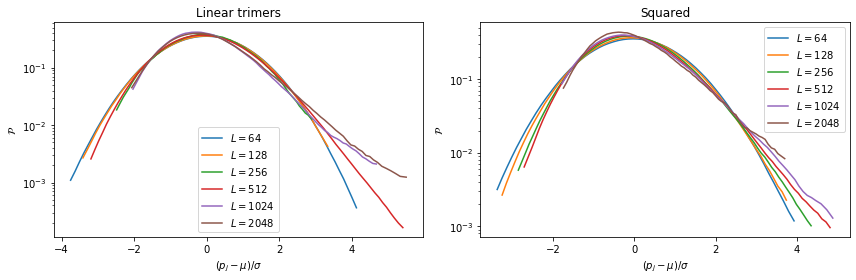

In [20]:
polys = np.unique( [ d['dep_polymers'] for d in data ] )

for islog in False, True:
    splt.init( 1, len( polys ) )

    for p in ['Linear trimers','Squared']:
        splt.next()

        for d in data:
            if( d['dep_polymers'] != p ):
                continue

            # d['fits'] = fitter.entropyc_fits( d['xs'], x )
            # d['fits_x'] = x
            
            # plt.plot( x, d['fits']['GG']['est_y'], label="GG" )
            # plt.errorbar( x, y, np.sqrt( np.array ( y ) / rr ), color='k', marker='.', ls='' )

            rr = d['runned_replicas']
            x, y = fitter.rebin_n( d['h_x'], d['h'], 100 )

            # Normalize: zero mean, unitary std, unitary heigth
            mu = d['fits']['GG']['pars'][0]
            std = d['fits']['GG']['pars'][1]
            x = ( np.array( x ) - mu ) / std
            y = np.array( y ) / np.trapz( y, x )

            smooth_ampl = 15
            x = np.convolve( x, np.ones(smooth_ampl)/smooth_ampl, mode = 'valid' )
            y = np.convolve( y, np.ones(smooth_ampl)/smooth_ampl, mode = 'valid' )

            plt.plot( x, y, label=fr"$L={d['side']}$" )
    
        if( islog ):
            plt.yscale( 'log' )
        plt.legend()

        plt.xlabel( fr"$( p_j - \mu ) / \sigma$")
        plt.ylabel(fr"$\mathcal{{P}}$")
        
        plt.title( p )

    plt.tight_layout()
    
    if( islog ):
        plt.savefig( savedir + "superimposed_pdfs_log.pdf" )
        plt.savefig( savedir + "superimposed_pdfs_log.png" )
    else:
        plt.savefig( savedir + "superimposed_pdfs.pdf" )

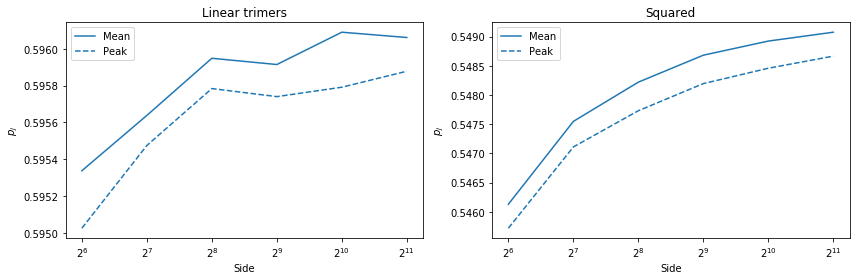

In [15]:
def get_GG_peak( d ):
    mu = data[d]['fits']['GG']['pars'][0]
    s  = data[d]['fits']['GG']['pars'][1]
    xs = np.linspace( mu - 3 * s, mu + 3 * s, 10000 )
    ys = fitter.GG( xs, 1, *data[d]['fits']['GG']['pars'] )
    return xs[ np.argmax( ys ) ]

splt.oneitem_iterate(
    len( data ),
    lambda d: data[d]['dep_polymers'],
    lambda d: 1,
    lambda d: data[d]['side'],
    lambda d: [
        data[d]['fits']['GG']['pars'][0],
        get_GG_peak( d )
    ],
    lambda it, l: [
        { 'label': fr"Mean", 'ls': '-', 'marker': ''  },
        { 'label': fr"Peak", 'ls': '--', 'marker': '' }
    ],
    lambda it: (
        plt.title( f"{it}" ),
        plt.xscale( 'log', basex = 2 ),
        # plt.yscale( 'log', basey = 10 ),
        plt.xlabel( fr"Side" ),
        plt.ylabel( "$p_j$" )
    )
)

plt.tight_layout()
